# Setup

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
xb = np.load('pred/feats_train.npy')
yb = np.load('pred/targs_train.npy')
xq = np.load('pred/feats_valid.npy')
yq = np.load('pred/targs_valid.npy')

In [4]:
xb.shape # nb-by-d

(575520, 512)

In [5]:
xq.shape # nq-by-d (query vectors)

(15476, 512)

In [6]:
yb.shape, yq.shape

((575520,), (15476,))

In [7]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 3034)

In [8]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [9]:
xb.max()

117.764336

In [10]:
faiss.normalize_L2(xb)

In [11]:
xb.max()

0.5498836

In [12]:
index.train(xb)

In [13]:
index.add_with_ids(xb, yb)

In [14]:
print(index.is_trained)
print(index.ntotal)

True
575520


## Train dataset

In [15]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[ 129  129  129  129  129]
 [1072 1072 1072 1072 1072]
 [  18   18   18   18   18]
 [1035 1035 1035 1035 1035]
 [ 401  401  401  401  401]]
[[ 129]
 [1072]
 [  18]
 [1035]
 [ 401]]
[[1.         0.9985957  0.9983933  0.9976785  0.99685204]
 [0.99999976 0.9988222  0.9985373  0.99787563 0.9975958 ]
 [0.9999998  0.99802375 0.9977718  0.9975278  0.9971471 ]
 [0.9999999  0.99572146 0.9955064  0.99545723 0.99516416]
 [0.9999998  0.96370625 0.9563191  0.9543669  0.9464225 ]]


In [16]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [17]:
I_train[:,0].shape, yb.shape

((575520,), (575520,))

In [18]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [19]:
I_train[:10,0], yb[:10]

(array([ 129, 1072,   18, 1035,  401,  434,  263,  649,  840,  492]),
 array([ 129, 1072,   18, 1035,  401,  434,  263,  649,  840,  492]))

In [20]:
I_train[-10:,0], yb[-10:]

(array([796, 272, 400, 995, 809, 928, 109, 830, 117, 994]),
 array([796, 272, 400, 995, 809, 928, 109, 830, 117, 994]))

### Train confusion matrix

In [21]:
#cm = confusion_matrix(I_train[:,0], yb)

In [22]:
#fig, ax = plt.subplots(figsize=(15,15))
#ax.matshow(cm, cmap='hot')

## Valid dataset

In [23]:
xq.max()

106.255394

In [24]:
faiss.normalize_L2(xq)

In [25]:
xq.max()

0.5085327

In [26]:
D_valid, I_valid = index.search(xq, k) # actual search

In [27]:
xq.shape, yq.shape

((15476, 512), (15476,))

In [28]:
I_valid.shape, D_valid.shape

((15476, 5), (15476, 5))

In [29]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[352 352 352 352 352]
 [744 611 611 744 744]
 [  6   6 503 503   6]
 [786 705 705 459 786]
 [ 70  91 397  91 647]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.7614977  0.7240968  0.71301746 0.7114304  0.70851225]
 [0.77093524 0.7668679  0.76513225 0.7637776  0.76227736]
 [0.7542646  0.7488384  0.7485517  0.7338048  0.7319501 ]
 [0.8671149  0.8668498  0.8586084  0.8492612  0.8484682 ]
 [0.86429214 0.8406039  0.8398144  0.8389016  0.838111  ]]


In [30]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[107 107 728 756 103]
 [822 822 822 822 822]
 [824 824 824 824 824]
 [589 589 589 589 589]
 [680 680 680 680 680]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[0.81584156 0.772703   0.7700645  0.7675833  0.757636  ]
 [0.789665   0.7845921  0.77704513 0.77666426 0.7752032 ]
 [0.901863   0.89953256 0.89788085 0.89780974 0.8956425 ]
 [0.7594192  0.75613284 0.75174844 0.74069446 0.73903966]
 [0.80862164 0.808396   0.8063409  0.7875677  0.7813009 ]]


In [31]:
np.save('pred/preds_valid.npy', I_valid)

### Valid accuracy

In [32]:
I_valid[:,0]

array([352, 744,   6, ..., 824, 589, 680])

In [33]:
yq

array([352, 361, 503, ..., 824, 328, 509])

In [34]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

9198

In [35]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.5943396226415094

In [36]:
valid_correct = np.equal(I_valid[:,0], yq)

In [37]:
valid_correct

array([ True, False, False, ...,  True, False, False])

In [38]:
np.save('pred/preds_valid_correct.npy', valid_correct)

### Valid confusion matrix

In [39]:
cm = confusion_matrix(I_valid[:,0], yq)

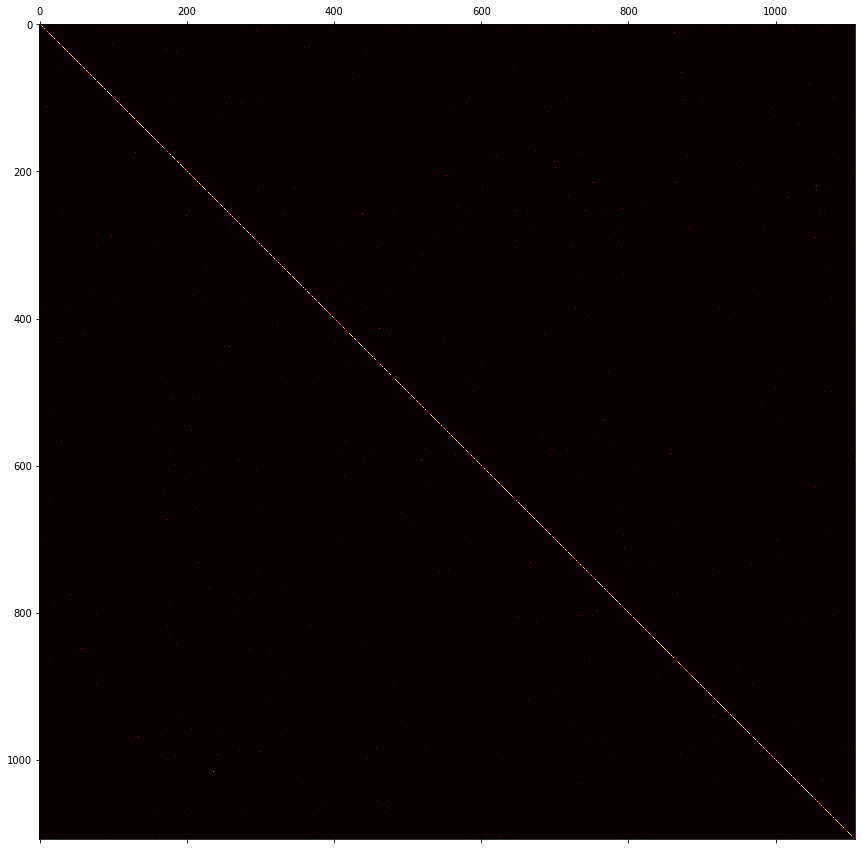

In [40]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

1506

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

6232

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.19462393383303178

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [41]:
xq_test = np.load('pred/feats_test.npy')

In [42]:
xq_test.max()

103.101555

In [43]:
faiss.normalize_L2(xq_test)

In [44]:
xq_test.max()

0.5108421

In [45]:
D_test, I_test = index.search(xq_test, k) # actual search

In [46]:
xq_test.shape, I_test.shape, D_test.shape

((39794, 512), (39794, 5), (39794, 5))

In [47]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[855 855 855 855 855]
 [773 773 773 773 773]
 [451 451 451 451 451]
 [200 200 200 200 200]
 [321 321 321 321 321]]
[[0.8050526  0.8023488  0.78692585 0.7841331  0.781307  ]
 [0.79362845 0.787942   0.78045076 0.76628935 0.7609991 ]
 [0.65830225 0.6135868  0.60747933 0.60559666 0.60076463]
 [0.7925312  0.78468895 0.7730044  0.7682063  0.7619917 ]
 [0.69687134 0.67010856 0.66153675 0.65859336 0.65420353]]


In [48]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[ 858  858  858  858  858]
 [ 926  926  926  926  926]
 [ 926  926  926  926  926]
 [ 636  636  636  636  636]
 [1086 1086 1086 1086 1086]]
[[0.5695647  0.56525373 0.5651256  0.5645833  0.5554249 ]
 [0.8032211  0.77192897 0.7669101  0.762678   0.7617196 ]
 [0.67199033 0.66126335 0.6601279  0.63869214 0.634481  ]
 [0.5108401  0.50896627 0.50514615 0.4914971  0.49058494]
 [0.72228456 0.7205719  0.71601397 0.71325386 0.7124178 ]]


In [49]:
I_test[2]

array([451, 451, 451, 451, 451])

In [50]:
np.unique(I_test[2], return_counts=True)

(array([451]), array([5]))

In [51]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [52]:
np.save('pred/preds_test.npy', preds_test)
np.save('pred/dist_test.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)